In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
# The next two lines are for optical reasons only. They can be safely disabled.
#Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
#Draw.DrawingOptions.atomLabelFontSize = 18

# GENERATE FINGERPRINT

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors, RDKFingerprint

# ===============================
# Fungsi-fungsi Fingerprint
# ===============================

# Morgan Fingerprints
def compute_morgan_fp(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))
    return [0] * n_bits  # Jika gagal parsing SMILES

# MACCS Keys
def compute_maccs_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(MACCSkeys.GenMACCSKeys(mol))
    return [0] * 167  # MACCS memiliki 167 bit

# Atom Pair Fingerprint (APF)
def compute_apf_fp(smiles, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=n_bits)
        return list(fp)
    return [0] * n_bits

# RDKit Fingerprint (RDK)
def compute_rdk_fp(smiles, max_path=7, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = RDKFingerprint(mol, maxPath=max_path, fpSize=n_bits)
        return list(fp)
    return [0] * n_bits


# ===============================
# Daftar file input
# ===============================
input_files = [
    r"C:\Fauzan\Manuscripts QSAR-RA 2\Old Endpoints\Acute Oral Toxicity (Manual split)\Read Across\Train_set_Oral_with_fingerprints.xlsx",
    r"C:\Fauzan\Manuscripts QSAR-RA 2\Old Endpoints\Acute Oral Toxicity (Manual split)\Read Across\Test_set_Oral_with_fingerprints.xlsx"
]

# ===============================
# Proses setiap file input
# ===============================
for input_path in input_files:
    print(f"Memproses file: {input_path}")
    df = pd.read_excel(input_path)

    # Cek kolom SMILES
    if "SMILES" not in df.columns:
        raise ValueError(f"Kolom 'SMILES' tidak ditemukan pada file: {input_path}")

    # Hitung fingerprint
    df["Morgan_Descriptors"] = df["SMILES"].apply(compute_morgan_fp)
    df["MACCS_Descriptors"] = df["SMILES"].apply(compute_maccs_fp)
    df["APF_Descriptors"] = df["SMILES"].apply(compute_apf_fp)
    df["RDK_Descriptors"] = df["SMILES"].apply(compute_rdk_fp)

    # Urutkan berdasarkan kolom Outcome jika ada
    if "Outcome" in df.columns:
        df_sorted = df.sort_values(by="Outcome", ascending=True)
    else:
        df_sorted = df

    # Simpan ke file baru
    folder = os.path.dirname(input_path)
    filename = os.path.splitext(os.path.basename(input_path))[0]
    output_path = os.path.join(folder, f"{filename}_fingerprints.xlsx")

    df_sorted.to_excel(output_path, index=False)
    print(f"✅ Hasil untuk '{input_path}' disimpan ke '{output_path}'.")

print("Selesai memproses semua file.")


# PRE-PROCESSING

Train Classes                          :  [0 1]
Train Number of compounds in each class:  [305, 306]
Train Total number of compounds        :  611
Train Class info mapping               :  {'0': 0, '1': 1}


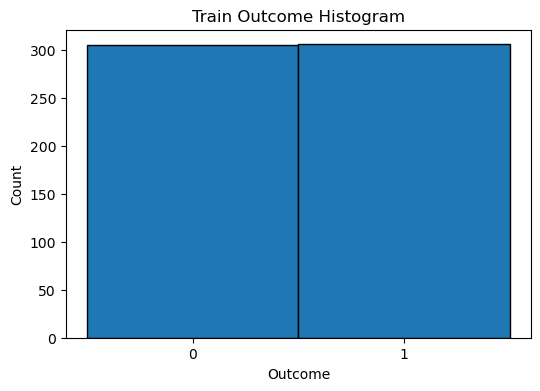

Test Classes                          :  [0 1]
Test Number of compounds in each class:  [77, 76]
Test Total number of compounds        :  153
Test Class info mapping               :  {'0': 0, '1': 1}


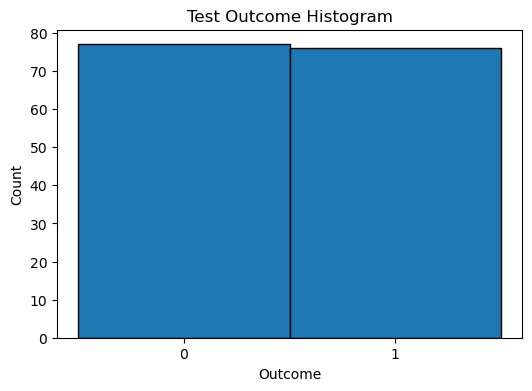

✅ Train shape: (611, 4263) (611,)
✅ Test shape : (153, 4263) (153,)


In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
import ast
import matplotlib.pyplot as plt

# ===============================================================
# Fungsi umum
# ===============================================================

def load_excel(file_path):
    """Load Excel file menjadi DataFrame."""
    df = pd.read_excel(file_path)
    return df

def convert_smiles_to_mol(df, smiles_col='SMILES'):
    """Konversi SMILES ke Mol."""
    if smiles_col not in df.columns:
        raise ValueError(f"❌ Column '{smiles_col}' not found!")
    df['Mol'] = df[smiles_col].apply(lambda x: Chem.MolFromSmiles(str(x)) if pd.notnull(x) else None)
    return df

def drop_duplicates_and_na(df, subset_cols=['SMILES']):
    """Buang duplikat dan NA."""
    df = df.drop_duplicates(subset=subset_cols).dropna()
    return df

def parse_fingerprint_column(column):
    """Parsing string list menjadi array numerik."""
    parsed = []
    for item in column:
        if isinstance(item, str):
            try:
                parsed.append(ast.literal_eval(item))
            except Exception:
                parsed.append([])
        else:
            parsed.append(item)
    return np.array(parsed, dtype=float)

def prepare_X_y(df, fingerprint_cols, outcome_col='Outcome'):
    """Prepare X dan y dari DataFrame."""
    # Outcome
    df[outcome_col] = df[outcome_col].astype(int)
    y = df[outcome_col].map({0: 0, 1: 1}).to_numpy(dtype=np.int32)
    
    # Fingerprints
    X_parts = [parse_fingerprint_column(df[col]) for col in fingerprint_cols]
    
    # Konsistensi jumlah sampel
    n_samples = {arr.shape[0] for arr in X_parts}
    if len(n_samples) != 1:
        raise ValueError("❌ Number of samples inconsistent across fingerprints!")
    
    # Concatenate semua fingerprint
    X = np.concatenate(X_parts, axis=1)
    return X, y

def check_numerical(data, name="Data"):
    """Validasi seluruh elemen numerik."""
    if not np.issubdtype(data.dtype, np.number):
        raise ValueError(f"❌ {name} contains non-numerical values!")

def plot_outcome_hist(y, bins=None, title="Outcome Histogram"):
    """Plot histogram outcome."""
    plt.figure(figsize=(6,4))
    plt.hist(y, bins=bins, edgecolor='k')
    plt.xticks(np.arange(0, np.max(y)+1))
    plt.title(title)
    plt.xlabel("Outcome")
    plt.ylabel("Count")
    plt.show()

# ===============================================================
# Paths & fingerprint columns
# ===============================================================
fingerprint_columns = [
    'Morgan_Descriptors',
    'MACCS_Descriptors',
    'APF_Descriptors',
    'RDK_Descriptors'
]

train_file = r"C:\Fauzan\Manuscripts QSAR-RA 2\Old Endpoints\Acute Dermal Toxicity (manual split)\Read Across\Train_set_Dermal_balanced_with_fingerprints.xlsx"
test_file  = r"C:\Fauzan\Manuscripts QSAR-RA 2\Old Endpoints\Acute Dermal Toxicity (manual split)\Read Across\Test_set_Dermal_balanced_with_fingerprints.xlsx"

# ===============================================================
# Load & clean data
# ===============================================================
train_df = load_excel(train_file)
train_df = convert_smiles_to_mol(train_df)
train_df = drop_duplicates_and_na(train_df)
train_df = train_df.sort_values(['Outcome'], ascending=True)

test_df  = load_excel(test_file)
test_df = convert_smiles_to_mol(test_df)
test_df = drop_duplicates_and_na(test_df)
test_df = test_df.sort_values(['Outcome'], ascending=True)

# ===============================================================
# Prepare X and y
# ===============================================================
x_train, y_train = prepare_X_y(train_df, fingerprint_columns)
x_test,  y_test  = prepare_X_y(test_df, fingerprint_columns)

# Validasi numerik
for arr, name in zip([x_train, x_test], ['Train X', 'Test X']):
    check_numerical(arr, name)

# ===============================================================
# Info outcome
# ===============================================================
def print_class_info(y, label="Dataset"):
    outcomes = np.unique(y)
    print(f"{label} Classes                          : ", outcomes)
    print(f"{label} Number of compounds in each class: ", [len(y[y==cls]) for cls in outcomes])
    print(f"{label} Total number of compounds        : ", len(y))
    info = {str(cls): i for i, cls in enumerate(outcomes)}
    print(f"{label} Class info mapping               : ", info)
    plot_outcome_hist(y, bins=np.arange(-0.5, np.max(y)+1, 1), title=f"{label} Outcome Histogram")
    return info

train_info = print_class_info(y_train, "Train")
test_info  = print_class_info(y_test, "Test")

# ===============================================================
# Print shapes
# ===============================================================
print("✅ Train shape:", x_train.shape, y_train.shape)
print("✅ Test shape :", x_test.shape, y_test.shape)


# Read Across with CI95%

In [ ]:
import numpy as np
import pandas as pd
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from sklearn.metrics import roc_auc_score, confusion_matrix
import ast
import os

# =========================================================
# Konversi Fingerprint
# =========================================================
def convert_list_to_bitvect(fp_list):
    if isinstance(fp_list, str):
        fp_list = ast.literal_eval(fp_list)
    n_bits = len(fp_list)
    bv = ExplicitBitVect(n_bits)
    for i, bit in enumerate(fp_list):
        if int(bit):
            bv.SetBit(i)
    return bv

def prepare_fingerprints(df, fingerprint_cols):
    fps_dict = {}
    for col in fingerprint_cols:
        fps_dict[col] = [convert_list_to_bitvect(x) for x in df[col]]
    return fps_dict

# =========================================================
# Helper: hitung BACC dari prob
# =========================================================
def compute_bacc_from_probs(y_true, y_prob, thresh=0.5):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = (np.asarray(y_prob) >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return 0.5 * (sens + spec)

# =========================================================
# Bootstrapping: median ± (max-min)/2 (tambahkan BACC)
# =========================================================
def bootstrap_ci_simple(y_true, y_prob, n_bootstrap=2000, seed=42):
    rng = np.random.default_rng(seed)
    metrics = {"Accuracy": [], "AUC": [], "Sensitivity": [], "Specificity": [], "BACC": []}

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    for _ in range(n_bootstrap):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        y_t = y_true[idx]
        y_p = y_prob[idx]
        preds = (y_p >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_t, preds).ravel()

        acc = (tp + tn) / (tp + tn + fp + fn)
        auc = roc_auc_score(y_t, y_p)
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        bacc = 0.5 * (sens + spec)

        metrics["Accuracy"].append(acc)
        metrics["AUC"].append(auc)
        metrics["Sensitivity"].append(sens)
        metrics["Specificity"].append(spec)
        metrics["BACC"].append(bacc)

    ci = {}
    for m, values in metrics.items():
        values = np.array(values)
        median = np.median(values)
        low = np.min(values)
        high = np.max(values)
        err = (high - low) / 2.0
        ci[m] = {"value": median, "error": err}
    return ci


def evaluate_model_with_ci_simple(y_true, y_pred_prob):
    ci = bootstrap_ci_simple(y_true, y_pred_prob)

    result = {}
    for m in ci:
        result[m] = ci[m]["value"]
        result[m + "_±"] = ci[m]["error"]
    return result

# =========================================================
# Read-Across: similarity-weighted kNN (Eq. 4)
# =========================================================
def compute_tanimoto_similarity(target_fp, reference_fps):
    return np.array([
        DataStructs.TanimotoSimilarity(target_fp, ref_fp)
        for ref_fp in reference_fps
    ])

def predict_properties_weighted(
    test_fps,
    train_fps,
    y_train,
    k=5,
    tanimoto_cutoff=0.0
):
    y_train = np.asarray(y_train, dtype=float)
    n_test = len(test_fps)
    probs = np.zeros(n_test, dtype=float)

    for i, test_fp in enumerate(test_fps):
        sims = compute_tanimoto_similarity(test_fp, train_fps)

        if tanimoto_cutoff > 0.0:
            valid_idx = np.where(sims >= tanimoto_cutoff)[0]
        else:
            valid_idx = np.arange(len(sims))

        if len(valid_idx) == 0:
            probs[i] = y_train.mean()
            continue

        sims_valid = sims[valid_idx]

        if len(sims_valid) > k:
            nn_local_idx = np.argsort(sims_valid)[-k:]
            nn_idx = valid_idx[nn_local_idx]
        else:
            nn_idx = valid_idx

        nn_sims = sims[nn_idx]
        nn_labels = y_train[nn_idx]

        weights = nn_sims.copy()
        if weights.sum() == 0:
            probs[i] = nn_labels.mean()
        else:
            probs[i] = np.sum(weights * nn_labels) / np.sum(weights)

    return probs

# =========================================================
# MAIN
# =========================================================
fingerprint_columns = [
    'Morgan_Descriptors',
    'MACCS_Descriptors',
    'APF_Descriptors',
    'RDK_Descriptors'
]

train_fingerprints = prepare_fingerprints(train_df, fingerprint_columns)
test_fingerprints  = prepare_fingerprints(test_df, fingerprint_columns)

y_train = train_df['Outcome'].values.astype(int)
y_test  = test_df['Outcome'].values.astype(int)

# 1) RA per fingerprint
k_neighbors = 5
tanimoto_cutoff = 0.0

predicted_probabilities = {}
single_fp_metrics = {}

for fp in fingerprint_columns:
    probs = predict_properties_weighted(
        test_fps=test_fingerprints[fp],
        train_fps=train_fingerprints[fp],
        y_train=y_train,
        k=k_neighbors,
        tanimoto_cutoff=tanimoto_cutoff
    )
    predicted_probabilities[fp] = probs
    single_fp_metrics[fp] = evaluate_model_with_ci_simple(y_test, probs)

# 2) Baca Sf dari CSV (AUC,BACC dari 10-fold scaffold-CV)
sf_path = r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Acute Dermal Toxicity\Read Across\Sf_per_fingerprint.csv"
sf_df = pd.read_csv(sf_path)

Sf = {}
for fp in fingerprint_columns:
    row = sf_df.loc[sf_df["Fingerprint"] == fp]
    if row.empty:
        raise ValueError(f"Sf untuk fingerprint {fp} tidak ditemukan di {sf_path}")
    Sf[fp] = float(row["Sf"].values[0])

sum_Sf = sum(Sf.values())
vf = {fp: Sf[fp] / sum_Sf for fp in fingerprint_columns}

# 3) Konsensus RA
consensus_pred_probabilities = np.zeros(len(y_test), dtype=float)
for fp in fingerprint_columns:
    consensus_pred_probabilities += vf[fp] * predicted_probabilities[fp]

test_df['Read_Across_Probabilities'] = consensus_pred_probabilities

metrics_ra = evaluate_model_with_ci_simple(y_test, consensus_pred_probabilities)

print("\n--- Consensus Read-Across Performance (median ± range/2) ---")
for k in ["AUC", "Accuracy", "BACC", "Sensitivity", "Specificity"]:
    val = metrics_ra[k]
    err = metrics_ra[k + "_±"]
    print(f"{k}: {val:.4f} ± {err:.4f}")

# 4) Simpan ringkasan per fingerprint
rows = []
for fp in fingerprint_columns:
    m = single_fp_metrics[fp]
    rows.append({
        "Fingerprint": fp,
        "Sf": Sf[fp],
        "Weight_vf": vf[fp],
        "AUC": m["AUC"], "AUC_±": m["AUC_±"],
        "Accuracy": m["Accuracy"], "Accuracy_±": m["Accuracy_±"],
        "BACC": m["BACC"], "BACC_±": m["BACC_±"],
        "Sensitivity": m["Sensitivity"], "Sensitivity_±": m["Sensitivity_±"],
        "Specificity": m["Specificity"], "Specificity_±": m["Specificity_±"],
    })

results_df = pd.DataFrame(rows).sort_values(by="Sf", ascending=False)

output_path = r"C:\Fauzan\Manuscripts QSAR-RA 2\q-RASAR\Acute Dermal Toxicity\Read Across\ReadAcross_Consensus_RA.xlsx"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
results_df.to_excel(output_path, index=False)

print("\nRingkasan RA per fingerprint + Sf dan v_f disimpan ke:")
print(output_path)
